In [101]:
import numpy as np
import igraph as ig
from ripser import ripser
from persim import plot_diagrams
from numba import jit
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '/Users/CarolineHerr/Documents/GitHub/Preferential_Attachment_Clique_Complex')
from simulator_pa import pa_generator
import betti

import matplotlib.pyplot as plt

## Graph Generation and Parameter Selection

We'll first generate a scale-free graph using preferential attachment using the function pa_generator, which can be found in simulator_pa.py. (cite section from paper). The function will output an iGraph object simulated using the preferential attachment model.

The necessary parameters are:

num_nodes (int): Number of nodes in the graph (referred as $t$, i.e. how long the model is simulated for).

num_edges_per_new_node (int): Number of edges attached to the new node each time (referred as $m$).

$\delta$ (float): Parameter to control the rich-gets-richer effect. For smaller (more negative) delta, the effect is stronger.
        The power of of the tail of the degree distribution should be $\tau = 3 + \delta / m$.
        We choose -m < $\delta$ < 0 to ensure 2 < $\tau$ < 3.
        
seed (int): Seed for the random number geneator.

Because we're interested in the homology of the complex and scale-free network, we tend to select large m and smaller $\delta$ for more interesting results. 

In this tutorial, we'll work with $m = 7, \delta = -5$.

In order to make the visualize more interpretable, we'll use smaller num_nodes.


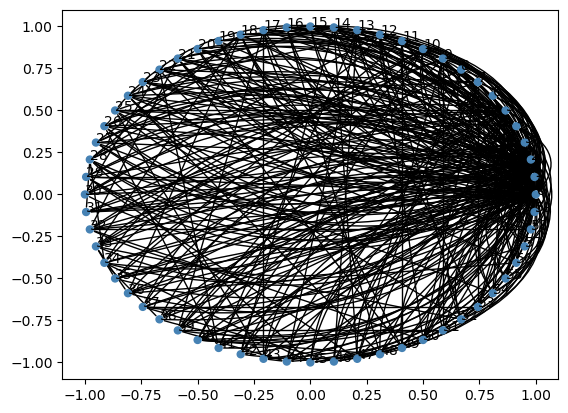

In [102]:
m = 7
delta = -5
T0 = 60
seed = 64
graph = pa_generator(T0, m, delta, seed)
layout = graph.layout_circle()
labels = [x for x in range(T0)]

fig, ax = plt.subplots()
ig.plot(graph, target = ax, layout=layout, vertex_label = labels, bbox=(0, 0, 350, 350))

We can observe from the plot that the graph is likely scale-free, since there are a few nodes (typically nodes appearing early) with very high degrees, while the rest have lower degrees. We'll now generate a graph with larger t, with other parameters staying the same, to produce more interesting results about homology.

In [103]:
num_nodes = 5000
graph = pa_generator(num_nodes, m, delta, seed)

## Betti Numbers Calculation

We'll now calculate the Betti numbers using Ripser, which helps us obtain the persistence diagram of the complex. In this example, we'll focus on Betti numbers at the 2nd dimension.

We'll first demonstrate Ripser in a simple example, with four nodes and four edges forming a square.

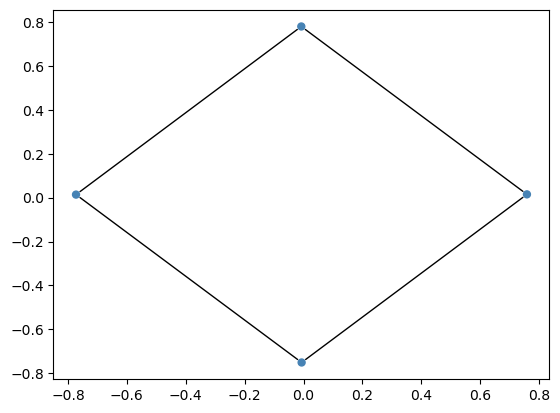

In [104]:
small_graph = ig.Graph()
small_graph.add_vertices(4)
small_graph.add_edges([(0,1), (1,2), (2,3), (3,0)])
fig, ax = plt.subplots()
ig.plot(small_graph, target = ax, bbox=(0, 0, 200, 200))

To use Ripser, we'll use the function get_adge_matrix() from betti.py, which constructs a matrix describing the age of each edge and vertex. Ripser takes the matrix and a maximum dimension as inputs to form the persistent diagram. The function translate_PD_to_betti() takes the persistent diagram and t as an input to calculate the betti number.

Betti 1 at each time is: [0. 0. 0. 1.]


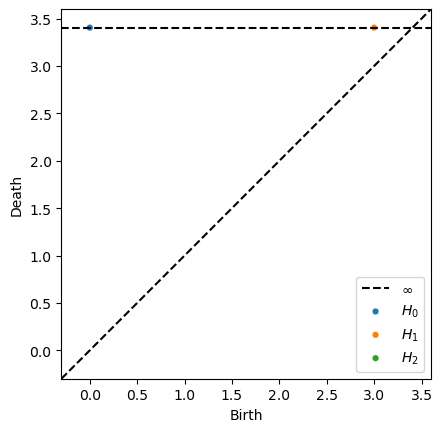

In [105]:
mat = betti.get_age_matrix(small_graph)
dgms = ripser(mat, distance_matrix=True, maxdim=2)['dgms']
print('Betti 1 at each time is: ' + str(betti.translate_PD_to_betti(dgms[1], 4)))
plot_diagrams(dgms)

The orange dot indicates that a 1-dim hole is born at time = 3, as the square is formed. Betti 1 is calculated to be [0,0,0,1], since the first hole appears at time = 3. Now, let's fill the square and see what happens.

Betti 1 at each time is: [0. 0. 0. 1. 0.]


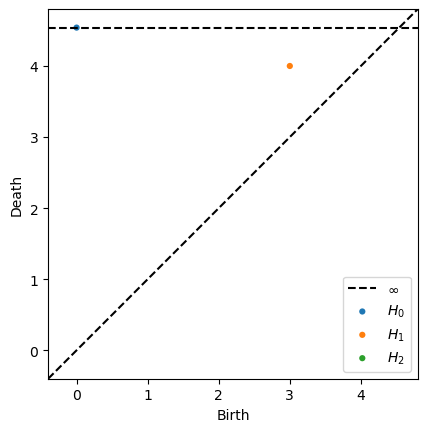

In [106]:
small_graph.add_vertices(1)
small_graph.add_edges([(4,0),(4,1),(4,2),(4,3)])
mat = betti.get_age_matrix(small_graph)
dgms = ripser(mat, distance_matrix=True, maxdim=2)['dgms']
print('Betti 1 at each time is: ' + str(betti.translate_PD_to_betti(dgms[1], 5)))
plot_diagrams(dgms)

Since the square is filled by the new node, the hole we saw previously "dies" at time = 4, so the orange dot is shown to be born at time = 3, and dies at time = 4. Correspondingly, Betti 1 goes back to 0 at time = 4.

Now, let's do the same calculation for our larger graph.

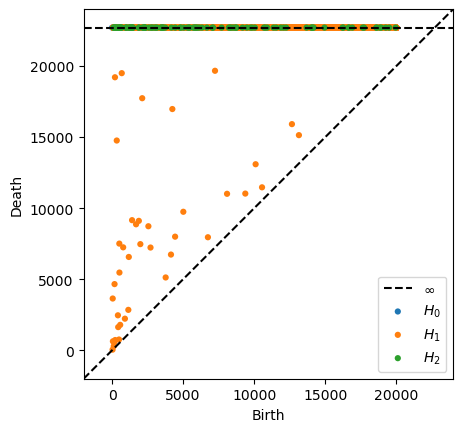

In [107]:
mat = betti.get_age_matrix(graph) # obtain the age matrix of the complex as an input for ripser
dgms = ripser(mat, distance_matrix=True, maxdim=2)['dgms'] # get the persistence diagrams
plot_diagrams(dgms)

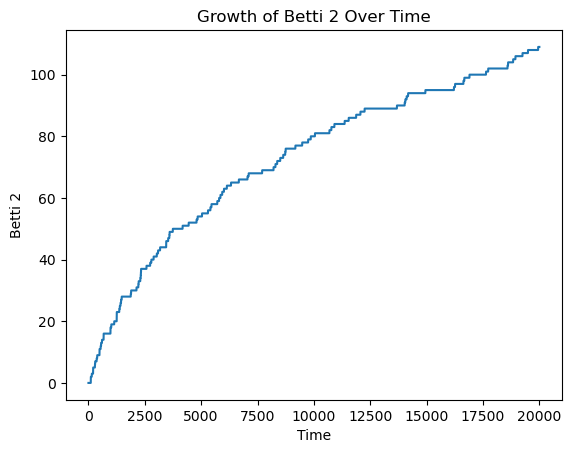

In [108]:
betti2_actual = betti.translate_PD_to_betti(dgms[2], num_nodes) # read the betti numbers from persistence diagrams
plt.plot(betti2_actual)
plt.xlabel('Time')
plt.ylabel('Betti 2')
plt.title('Growth of Betti 2 Over Time')
plt.show()

## Upper Bound of Betti Number

The above plot shows the growth of 2nd dimensional betti numbers over time. We'll now investigate the upper bounds and lower bounds. The detailed proofs for the bounds can be found in the paper in section 4 and 5.

The upper bound is found by $$\beta_q \leq \sum_{t \leq T} \text{rk } H_{q-1}(L^{(t)})$$ 
i.e., the cumulative sum of Betti q-1 of each node's link, where q represents the dimension (2 in our case).

In [109]:
def betti_numbers_of_links(graph, num_nodes, m, maxdim):
    """
    Return the upper bound for Betti 2 by finding the cumulative sum of Betti 1 of each node's link
    
    OUTPUT
    betti 2 upper bound at each time step as a list
    
    INPUT
    graph: igraph object
    
    """
    
    edge_list = np.array([e.tuple for e in graph.es])
    
    start = 0
    end = m
    betti_nums = np.zeros((maxdim + 1, num_nodes))
    current_node = 1

    for current_node in range(1, num_nodes):
        start = (current_node - 1) * m
        end = current_node * m
    #while start < len(edge_list) and end <= len(edge_list):

        # find the link of each node
        link_list = edge_list[start:end, 0]
        link_list = np.unique(link_list)

        # generate subgraph for the link
        subgraph = graph.induced_subgraph(link_list)

        # count the betti numbers
        mat = betti.get_age_matrix(subgraph)
        dgms = ripser(mat, distance_matrix=True, maxdim=maxdim)['dgms']
        
        for dim in range(maxdim):
            for k, j in dgms[dim]:
                if j == np.inf: betti_nums[dim, current_node] += 1

        current_node += 1
        start += m
        end += m

    return betti_nums

In [110]:
links_betti_nums = betti_numbers_of_links(graph, num_nodes, m, maxdim = 2)
betti2_upper = np.cumsum(links_betti_nums[1, :])

## Lower Bound of Betti Number

The lower bound consists of three terms: $$\beta_q \geq \sum_{t \leq T} (\ell^{(t)} - b^{(t)}_{MC} - b^{(t)}_{KL})$$ where $$\ell^{(t)} = \mathbf{1}[(S^q)^{(t)}] $$

$$b^{(t)}_{MC} = \mathbf{1}[(S^q)^{(t)} \text{and rk ker }f_{q-1} = 0] $$

$$b^{(t)}_{KL} = \text{rk } H_q (L^{(t)})$$

Please refer to Proposition 14 in paper for explanations of notations and details.

In [111]:
# helper functions for lower bound calculation

@jit(nopython=True)
def first_summand_lower_bound(edge_list, num_nodes, m, square, latest_node_in_square, numba_flag=True):

    first_summand = np.zeros(num_nodes) # numba does not like integer arrays
    found_one_flag = 0
    for i in range(latest_node_in_square + 1, num_nodes):
        if True:
            fill = betti.check_node_square_connection(
                edge_list, i, square, m = m)
        if fill:
            if found_one_flag == 0:  # The first filling does not count
                found_one_flag = 1
            else:
                first_summand[i] = 1

    return first_summand

def second_summand_lower_bound(edge_list, num_nodes, square, first_summand):
    
    latest_node_in_square = max(square)
    second_summand = np.zeros(num_nodes, dtype = int)
    for i in range(latest_node_in_square + 1, num_nodes):
        if first_summand[i] >= 1:
            mat = betti.get_link_matrix(graph, square, i)
            dgms = ripser(mat, distance_matrix=True, maxdim=1)['dgms']
            second_summand[i] = int(
                any([pt[1] == 2 for pt in dgms[1]])
            )
    return second_summand

In [112]:
# Structural changes above:
# I removed inputs that were not actually used.
# I make the inputs actual objects that are called because they are internal functions anyway.
# All the outputs are now terms to be summed. Before some of them have been summed while the others were not. This was confusing.
# Accordingly, I renamed the outputs as summands rather than terms to emphasize that they need to be summed.
# I store the output as a numpy array instead of a list to avoid numba headache. Usually, numpy arrays are better if you know the length of a numerical list in advance.

# Aesthetic changes above:
# I renamed largest_square_node as latest_node_in_square for easier understanding.
# I renamed t as num_nodes. t is confusing.

In [113]:
def betti2_lower_bound(graph, time = 20, first_summand = None, second_summand = None, links_betti_nums = None):

    """
    Return the lower bound of Betti 2. 
    The lower bound is found by the above inequality.
    
    OUTPUT
    Betti 2 lower bound at each time step as a list
    
    INPUT
    graph: igraph object
    time: the time constraint for the appearance of the square
    """
    
    edge_list = np.array([e.tuple for e in graph.es])
    num_nodes = graph.vcount()
    m = int(len(edge_list)/(num_nodes - 1))
    
    # find if there's a square in the first 20 nodes
    boo, square = betti.check_square_appearance(graph, time)
    
    if not boo:
        first_term = np.zeros(num_nodes, dtype = int)
    else:
        latest_node_in_square = max(square)
        if first_summand is None:
            first_summand = first_summand_lower_bound(edge_list, num_nodes, m, square, latest_node_in_square)
            first_summand = first_summand.astype(int)
        first_term = np.cumsum(first_summand)

    if not boo:
        second_term = np.zeros(num_nodes, dtype = int)
    else:
        if second_summand is None:
            second_summand = second_summand_lower_bound(edge_list, num_nodes, square, first_summand)
        second_term = np.cumsum(second_summand)

    if links_betti_nums is None:
        links_betti_nums = betti_numbers_of_links(graph, num_nodes, m, maxdim = 2)
    
    third_term = np.cumsum(links_betti_nums[2, :])
    
    return first_term - second_term - third_term, first_summand, second_summand, links_betti_nums

In [114]:
betti2_lower, first_summand, _, _ = betti2_lower_bound(graph, num_nodes, links_betti_nums = links_betti_nums)

True
hi
hi


In [115]:
print(sum(first_summand))

0


## Result Replications
Now, we can plot the the actual Betti numbers, the upper bound, and the lower bound to verify that the bounds hold for the graph we generated.

Text(0.5, 1.0, 'Betti 2 and its Bounds')

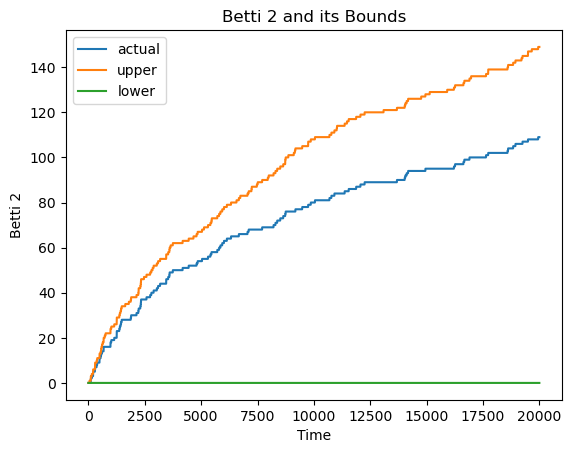

In [116]:
fig, ax = plt.subplots()
ax.plot(betti2_actual, label = 'actual')
ax.plot(betti2_upper, label = 'upper')
ax.plot(betti2_lower, label = 'lower')
ax.legend()
ax.set_xlabel('Time')
ax.set_ylabel('Betti 2')
ax.set_title('Betti 2 and its Bounds')

We can repeat similar calculations to find the mean of Betti numbers to observe behavior. The simulation we used in the paper generates 500 graphs of T = 10^4, and takes the sample mean of the Betti numbers. We'll follow the same parameter, but the simulation could take a very long time. Feel free to modify the parameters to reduce the runtime. 

In [ ]:
n_samples = 500
num_nodes = 5000
betti2_actual_mean = np.zeros(num_nodes)
betti2_upper_mean = np.zeros(num_nodes)
betti2_lower_mean = np.zeros(num_nodes)
for n in range(n_samples):

    graph = pa_generator(num_nodes, m, delta, n**3)
    mat = betti.get_age_matrix(graph)
    dgms = ripser(mat, distance_matrix=True, maxdim=2)['dgms']
    betti2_actual_mean += betti.translate_PD_to_betti(dgms[2], num_nodes)
    
    links_betti_nums = betti_numbers_of_links(graph, num_nodes, m, maxdim = 2)
    betti2_upper_mean += np.cumsum(links_betti_nums[1, :])
    
    betti2_lower, first_summand, _, _ = betti2_lower_bound(graph, num_nodes, links_betti_nums = links_betti_nums)
    betti2_lower_mean += betti2_lower
    
    print(sum(first_summand))
    
betti2_actual_mean /= n_samples
betti2_upper_mean /= n_samples
betti2_lower_mean /= n_samples

fig, ax = plt.subplots()
ax.plot(betti2_actual_mean, label = 'actual')
ax.plot(betti2_upper_mean, label = 'upper')
ax.plot(betti2_lower_mean, label = 'lower')
ax.title('Average Betti 2 and its Bounds')

True
hi
hi
0
True
hi
hi
0
True
hi
hi
0
True
hi
hi
0
True
hi
hi
4
True
hi
hi
4
True
hi
hi
0
True
hi
hi
0
True
hi
hi
0
True
hi
hi
0
True
hi
hi
0
True
hi
hi
0
True
hi
hi
0
True
hi
hi
0
True
hi
hi
5
True
hi
hi
0
True
hi
hi
0
True
hi
hi
0
True
hi
hi
0
True
hi
hi
0
True
hi
hi
0
True
hi
hi
7
True
hi
hi
4
True
hi
hi
0
True
hi
hi
0
True
hi
hi
0
True
hi
hi
2
True
hi
hi
0
True
hi
hi
0
True
hi
hi
0
True
hi
hi
0
True
hi
hi
0
True
hi
hi
15
True
hi
hi
1
True
hi
hi
0
True
hi
hi
0
True
hi
hi
0
True
hi
hi
2
True
hi
hi
0
True
hi
hi
0
True
hi
hi
0
True
hi
hi
0
True
hi
hi
0
True
hi
hi
0
True
hi
hi
0
True
hi
hi
1
True
hi
hi
0
True
hi
hi
0
True
hi
hi
1
True
hi
hi
0
True
hi
hi
1
True
hi
hi
0
True
hi
hi
0
True
hi
hi
0
True
hi
hi
0
True
hi
hi
0
True
hi
hi
0
True
hi
hi
0
True
hi
hi
1
True
hi
hi
0
True
hi
hi
0
True
hi
hi
0
True
hi
hi
0
True
hi
hi
0
True
hi
hi
2
True
hi
hi
0
True
hi
hi
0
True
hi
hi
0
True
hi
hi
6
True
hi
hi
0
True
hi
hi
2
True
hi
hi
0
True
hi
hi
0
True
hi
hi
0
True
hi
hi
0
True
hi
hi
0
True
hi
hi


Although convergence is slow, it is obvious that the curves are concave, so the slopes are decreasing. 